# Disjoint

This is a main development notebook used for test data generation and benchmark analysis. The main goal is to see how algorithm design and data distribution impact the runtime cost of finding unique sets in a set of sets.

In [1]:
import itertools as it

from typing import List

import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd
import polars as pl
import seaborn as sns

import dispy

from benchmark import SAMPLING_FUNCTIONS, SEARCH_SPACE, TB_ALGOS

In [2]:
ALGO_NAMES = list(TB_ALGOS.keys())
SAMPLING_NAMES = list(SAMPLING_FUNCTIONS.keys())

In [3]:
PARAM_KEYS = ["unique-subsets", "subset-size", "sample-size"]

df_distr = pl.DataFrame(
    {k: v for k, v in zip(PARAM_KEYS, vals)} | {"foo": np.arange(0, 5)}
    for vals in it.product(*tuple(SEARCH_SPACE[key] for key in PARAM_KEYS))
)

df_distr

unique-subsets,subset-size,sample-size,foo
i64,i64,i64,object
128,64,64,[0 1 2 3 4]
128,64,128,[0 1 2 3 4]
128,64,512,[0 1 2 3 4]
128,64,1024,[0 1 2 3 4]
128,64,2048,[0 1 2 3 4]
128,64,4096,[0 1 2 3 4]
128,64,8192,[0 1 2 3 4]
128,512,64,[0 1 2 3 4]
128,512,128,[0 1 2 3 4]


In [4]:
def gen_rng_sets(
    gen: np.random.Generator, n_sets: int, set_size: int
) -> np.ndarray:
    """Generates N binary vectors representing item sets.

    Args:
        gen: A numpy.random.Generator object.
        n_sets: A number of sets to generate.
        set_size: A set size.

    Returns:
        A 2d matrix as a numpy.ndarray object where each row is an unique set.
    """
    return gen.integers(2, size=[n_sets, set_size])


def gen_uniq_rng_set(
    n_sets: int, set_size: int, seed: int = 42, iterations: int = int(1e5)
) -> np.ndarray:
    """Generates N unique binary sets of fixed size.
    Args:
        n_sets: A number of sets to generate.
        set_size: A set size.
        seed: A seed used for constructing a random number generator.
        iterations: A number of iterations after which the function quits
            attempting to construct new unique subsets and returns the best
            possible result.

    Returns:
        A 2d matrix as a numpy.ndarray object where each row is an unique set.
    """
    dst = np.empty((0, set_size), dtype=np.int32)
    gen = np.random.default_rng(seed=seed)
    for _ in range(int(iterations)):
        dst = np.unique(
            np.vstack(
                (
                    dst,
                    gen_rng_sets(
                        gen,
                        n_sets=n_sets - len(dst),
                        set_size=set_size,
                    ),
                )
            ),
            axis=0,
        )

        if len(dst) == n_sets:
            break

    return dst


def gen_uniform_indices(
    min_index,
    max_index,
    sample_size: int,
    seed=42,
) -> np.ndarray:
    """Generate random indices in a given range following an uniform distribution.

    Args:
        min_index: A min index in a population.
        max_index: A max index in a population.
        sample_size: A number of random indices to generate.
        seed: A random seed.

    Return:
        An array of uniformly sampled random indices.
    """
    np.random.seed(seed)
    return np.random.randint(min_index, max_index, sample_size)


def gen_noraml_indices(
    min_index: int, max_index: int, sample_size: int, seed=42
) -> np.ndarray:
    """Generate random indices in a given range following the normal distribution.

    Args:
        min_index: A min index in a population.
        max_index: A max index in a population.
        sample_size: A number of random indices to generate.
        seed: A random seed.

    Return:
        An array random indices.
    """

    np.random.seed(seed)
    population_size = max_index - min_index

    return np.clip(
        np.random.normal(
            population_size / 2,
            np.sqrt(
                np.sum(
                    (np.arange(0, population_size) - (population_size / 2))
                    ** 2
                )
                / population_size
            )
            / 3,
            sample_size,
        ).astype(np.uint64),
        0,
        population_size,
    )

In [5]:
params = [
    {k: v for k, v in zip(PARAM_KEYS, vals)}
    for vals in it.product(*tuple(SEARCH_SPACE[key] for key in PARAM_KEYS))
]

df_distr = pl.DataFrame(
    ps
    | {
        "uniform": pl.Series(
            gen_uniform_indices(0, ps["unique-subsets"], ps["sample-size"])
        ),
        "normal": pl.Series(
            gen_noraml_indices(0, ps["unique-subsets"], ps["sample-size"])
        ),
    }
    for ps in params
)

df_distr = df_distr.filter(
    pl.col("subset-size") == pl.col("subset-size").min()
).explode("uniform", "normal")

df_distr

unique-subsets,subset-size,sample-size,uniform,normal
i64,i64,i64,i64,u64
128,64,64,102,70
128,64,64,51,62
128,64,64,92,71
128,64,64,14,82
128,64,64,106,61
128,64,64,71,61
128,64,64,60,83
128,64,64,20,73
128,64,64,102,58


In [18]:
sns.set_color_codes('colorblind')
palette = sns.color_palette(
    'colorblind', 
    n_colors=2,
)

hue_colors = {
    'uniform': palette[0],
    'normal': palette[1],
}

<Figure size 640x480 with 0 Axes>

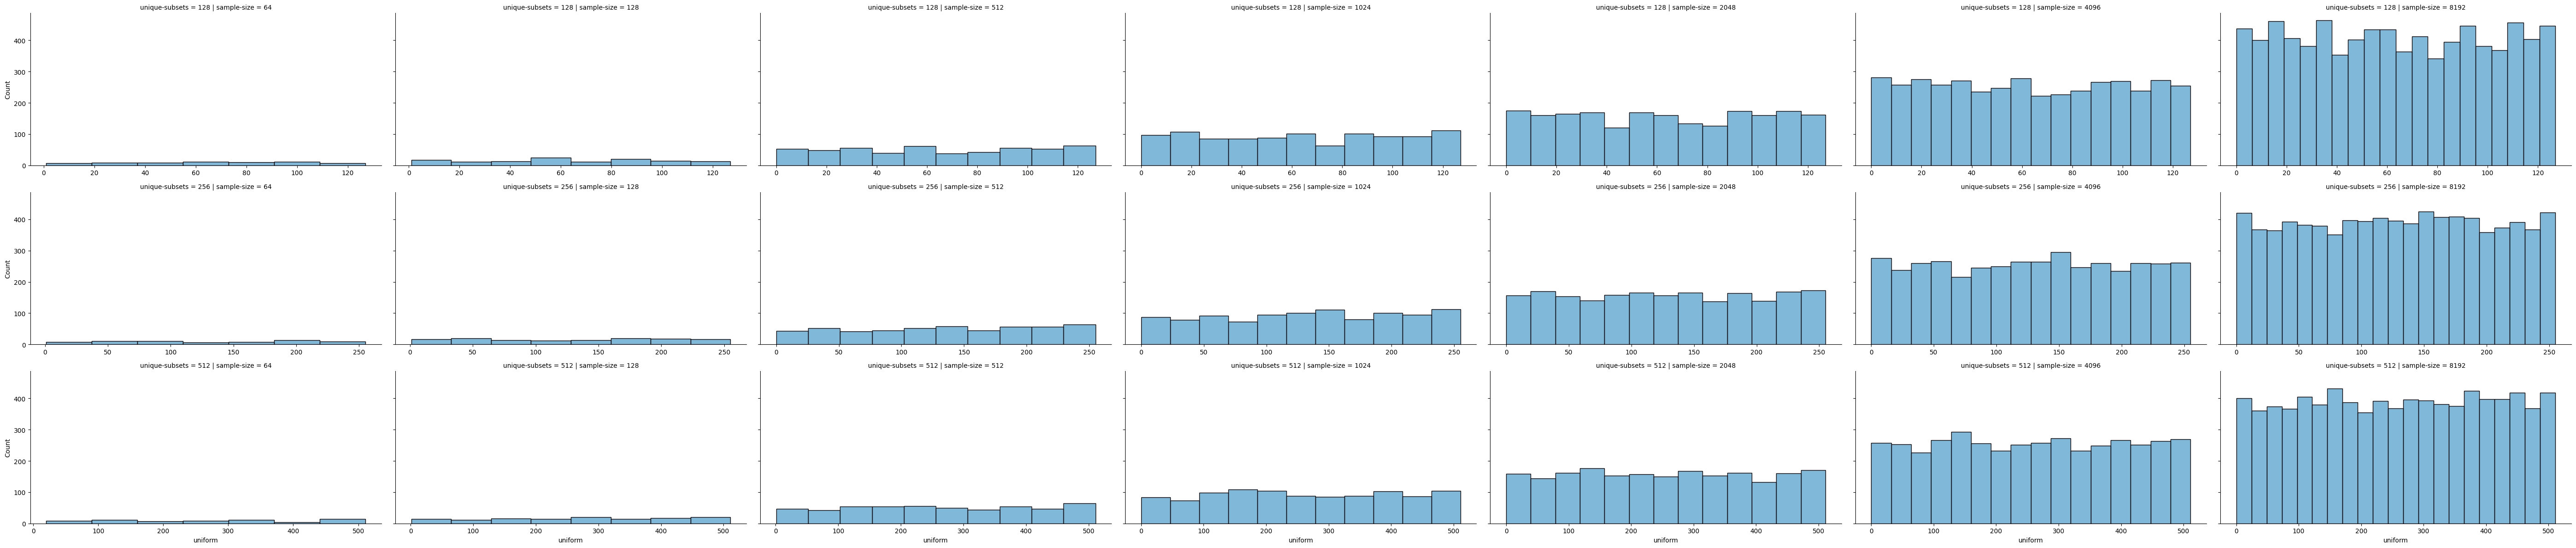

In [19]:
plt.tight_layout()
g = sns.FacetGrid(
    df_distr.with_columns(
        pl.lit("uniform").alias("distr")
    ).to_pandas(),
    row="unique-subsets",
    col="sample-size",
    sharex=False,
    height=4,
    aspect=1.33,
)
g.map_dataframe(sns.histplot, x="uniform", hue="distr", palette=hue_colors)
g.figure.subplots_adjust(right=1.5)

<Figure size 640x480 with 0 Axes>

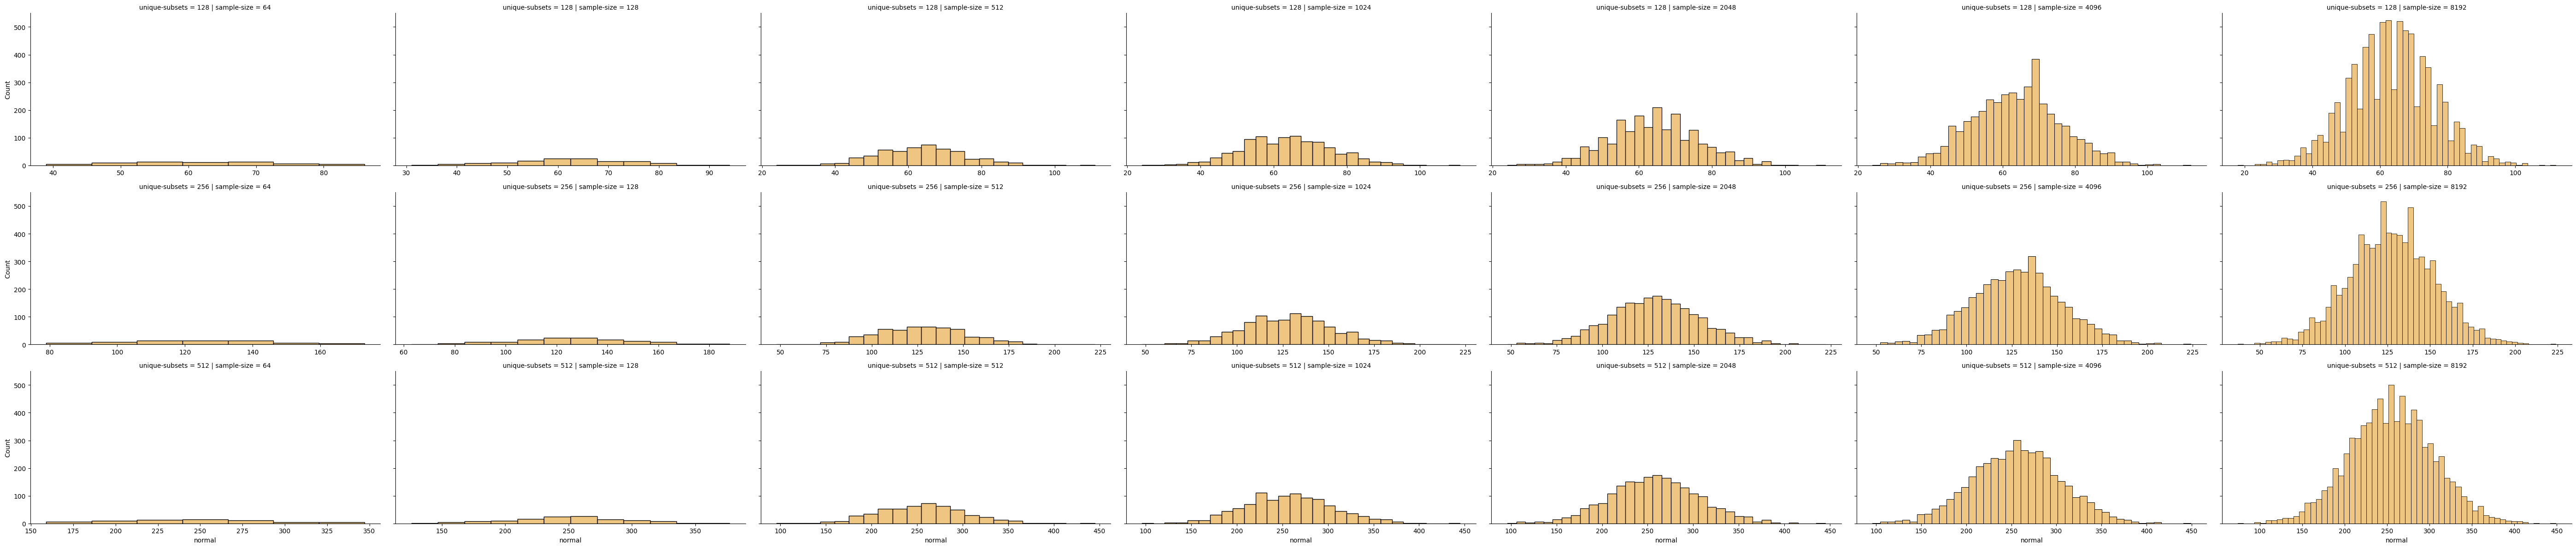

In [22]:
plt.tight_layout()
g = sns.FacetGrid(
    df_distr.with_columns(
        pl.lit("normal").alias("distr")
    ).to_pandas(),
    row="unique-subsets",
    col="sample-size",
    sharex=False,
    height=4,
    aspect=1.33,
)
g.map_dataframe(sns.histplot, x="normal", hue="distr", palette=hue_colors)
g.figure.subplots_adjust(right=1.5)

In [41]:
COLUMN_NAMES = [
    "name",
    "sample",
    "algo",
    "unique-subsets",
    "subset-size",
    "sample-size",
]

with open("../misc//bench.json", "r") as f:
    bench_data = json.load(f)

df_cpu_info = pl.DataFrame(
    {k: bench_data["context"][k] for k in ["num_cpus", "mhz_per_cpu"]}
)
df_context = pl.DataFrame(
    [
        cache | {"mhz_per_cpu": bench_data["context"]["mhz_per_cpu"]}
        for cache in bench_data["context"]["caches"]
    ]
)
df_benchmarks = pl.DataFrame(bench_data["benchmarks"]).with_row_count("id")

df_benchmarks = (
    df_benchmarks.select(
        pl.col("id"),
        pl.col("run_name").str.split("/").alias("values"),
        pl.lit("/".join(COLUMN_NAMES)).alias("metadata").str.split("/"),
        pl.col("real_time"),
        pl.col("cpu_time"),
    )
    .explode("values", "metadata")
    .pivot(
        values=["values"],
        index=["id"],
        columns=["metadata"],
    )
    .with_columns(
        pl.col("sample")
        .cast(pl.Int64)
        .map_elements(lambda x: SAMPLING_NAMES[x]),
        pl.col("algo").cast(pl.Int64).map_elements(lambda x: ALGO_NAMES[x]),
        pl.col("unique-subsets").cast(pl.Int64),
        pl.col("subset-size").cast(pl.Int64),
        pl.col("sample-size").cast(pl.Int64),
    )
    .join(
        df_benchmarks.select(
            [
                "id",
                pl.col("cpu_time").alias("cpu-time"),
                pl.col("real_time").alias("real-time"),
            ]
        ),
        on="id",
    )
)

df_benchmarks.head(n=5)

id,name,sample,algo,unique-subsets,subset-size,sample-size,cpu-time,real-time
u32,str,str,str,i64,i64,i64,f64,f64
0,"""tb_unique_algo…","""uniform""","""copy""",64,128,64,11815.221663,11850.548833
1,"""tb_unique_algo…","""normal""","""copy""",64,128,64,11437.615243,11481.287997
2,"""tb_unique_algo…","""uniform""","""unique""",64,128,64,18191.199149,18273.206567
3,"""tb_unique_algo…","""normal""","""unique""",64,128,64,19340.092649,19431.52038
4,"""tb_unique_algo…","""uniform""","""unique_binary""",64,128,64,81747.966396,82059.666089


In [42]:
df_context

type,level,size,num_sharing,mhz_per_cpu
str,i64,i64,i64,i64
"""Data""",1,32768,0,2300
"""Instruction""",1,32768,0,2300
"""Unified""",2,262144,2,2300
"""Unified""",3,6291456,0,2300


In [39]:
df_cpu_info

num_cpus,mhz_per_cpu
i64,i64
8,2300


<Figure size 640x480 with 0 Axes>

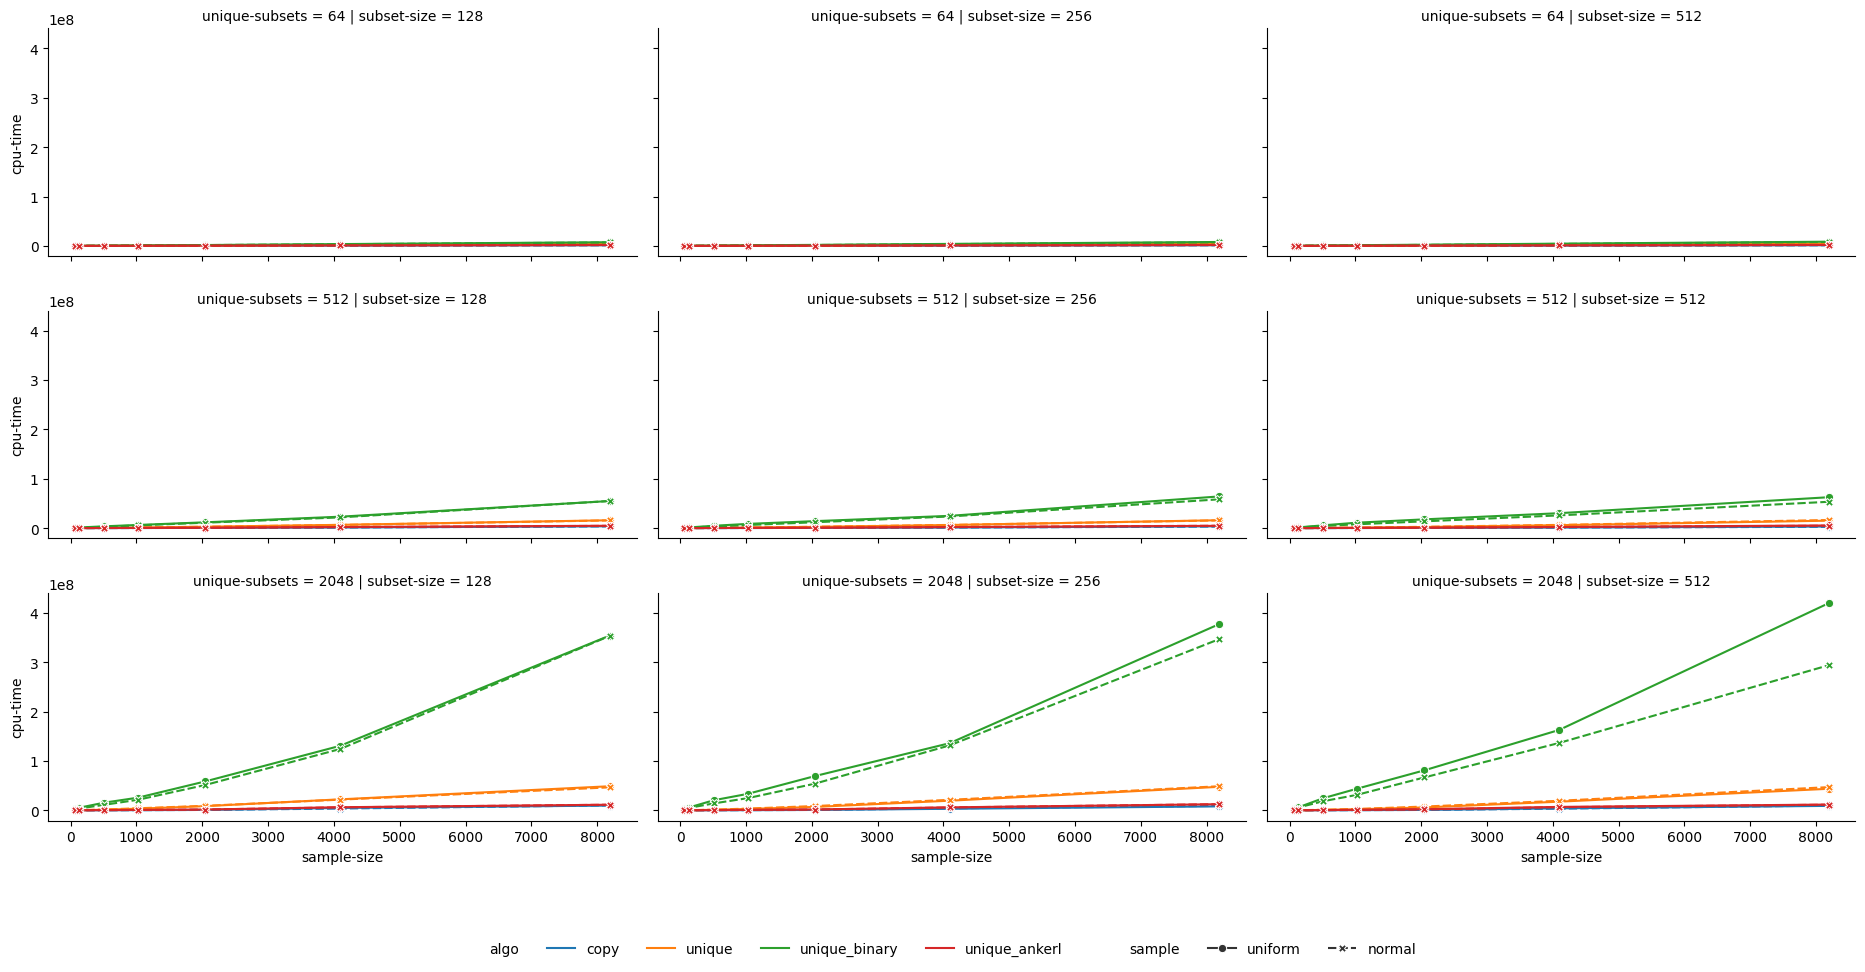

In [ ]:
df_plot = df_benchmarks.to_pandas()

plt.tight_layout()
g = sns.FacetGrid(
    df_plot,
    col="subset-size",
    row="unique-subsets",
)

g.map_dataframe(
    sns.lineplot,
    x="sample-size",
    y="cpu-time",
    hue="algo",
    style="sample",
    markers=True,
)
g.add_legend(bbox_to_anchor=(0.5, -0.1), loc="lower center", ncol=10)
g.fig.tight_layout()